In [3]:
% matplotlib inline

In [4]:
import tensorflow as tf
import pickle
import pandas as pd
import sys
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [5]:
class TF_Agent():
    
    def __init__(self, keys):
        self._initialize(keys)
        
    def _initialize(self, keys):
        np.random.seed(0)
        self.log_df = pd.DataFrame({key: [] for key in keys})
        self.keys = self.log_df.columns
        self.interesting = ",".join(self.log_df.columns)
        self.iter_count = 0     

    def set_batch(self, n, feed_dict):
        
        keys = list(feed_dict.keys())
        
        data_n = len(feed_dict[keys[0]])
        indices = np.random.choice(range(data_n), n, replace=False)
        
        feed_dict = {key: feed_dict[key][indices] for key in keys}
        self.feed_dict = feed_dict
    
    def run_session(self, sess):
        
        values = sess.run(eval(self.interesting),
                          feed_dict=self.feed_dict)
        
        self.recent_log = pd.Series(values, index=self.keys)
        self.log_df = self.log_df.append([self.recent_log])
        
        self.iter_count += 1
        
    def trace(self, args, one_line_text=""):
        
        iter_count = self.iter_count
        deco = ["-", "\\", "|", "/"][iter_count%4]
        
        one_line_text = "Iter: % 6d"%iter_count
        for arg in args:
            one_line_text += " %s %s: %0.9f"%(
                deco, arg, self.recent_log[arg]
            )

        sys.stdout.write("\r%s"%one_line_text)

In [34]:
def show_img_pair(sess, display_output, x, shape, transpose):
    
    recon = sess.run(display_output, feed_dict={X: [x]})
    
    recon = recon.reshape(*shape).transpose(*transpose)
    origin = x.reshape(*shape).transpose(*transpose)
    
    plots = [origin, recon]
    plot_n = len(plots)

    figsize = [6, 3]
    row_n, col_n = 1, 2
    margin = 0
    w = (1 - margin) / col_n
    h = (1 - margin) / row_n
    l = b = margin

    plt.figure(figsize=figsize)
    
    graphs = [plt.axes([l+w*(i%col_n), 
              b+h*(i//col_n), 
              w, h])
              for i in range(plot_n)]
    
    for i in range(plot_n):
        graph, plot = graphs[i], plots[i]
        graph.imshow(plot)
        graph.get_xaxis().set_visible(False)
        graph.get_yaxis().set_visible(False)
    
    plt.show()

In [35]:
img = plt.imread("./bg.jpeg")
recon_img = pickle.load(open("./recon_img", "rb"))
train_X = img.reshape(1, -1)

dataset = pd.read_pickle("./data/data_batch_1")
train_X = dataset["data"]

x_dim = train_X.shape[-1]

In [36]:
tf.reset_default_graph()
g = tf.get_default_graph()
tf.set_random_seed(0)

X = tf.placeholder(dtype=tf.float32, shape=[None, x_dim])
normalized_X = X/255

W = tf.Variable(tf.truncated_normal(shape=[x_dim, 1]))
b = tf.Variable(tf.truncated_normal(shape=[1, 1]))
L = tf.sigmoid(tf.matmul(X, W))

output = tf.sigmoid(tf.matmul(L, tf.transpose(W)))

display_output = output*255

loss = tf.losses.mean_squared_error(X, display_output)
learn = tf.train.AdamOptimizer().minimize(loss)

initializer = tf.global_variables_initializer()

In [37]:
tfa = TF_Agent(["loss", "learn"])
sess = tf.Session(graph=g)
sess.run(initializer)

Iter:  11000 - loss: 0.073044986834

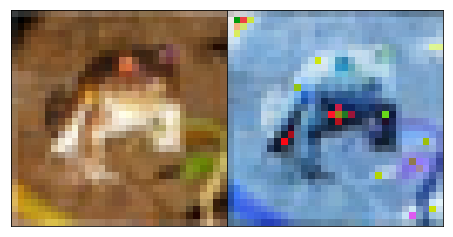

In [39]:
iter_n = 10000

for _ in range(iter_n):
    tfa.set_batch(1, {X: train_X[:1]})
    tfa.run_session(sess)
    tfa.trace(["loss"])
    
show_img_pair(sess, display_output, train_X[0], [3, 32, 32], [1, 2, 0])

In [154]:
sess.close()